In [1]:
import numpy as np
import pandas as pd

In [109]:
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.grid_search import RandomizedSearchCV
from sklearn.cross_validation import  cross_val_score

In [272]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, LeakyReLU, Dropout, Conv1D, MaxPool1D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import metrics

In [71]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

### General Settings

In [2]:
data_path = '../data/'

### HKRacing
This section contains code related to the dataset hkracing (https://www.kaggle.com/gdaley/hkracing/)

In [156]:
data_subdomain = 'hkracing/'

df_races = pd.read_csv(data_path + data_subdomain + 'races.csv', date_parser=['date'])
df_runs = pd.read_csv(data_path + data_subdomain + 'runs.csv')

In [12]:
df_races.head()

,race_id,date,venue,race_no,config,surface,distance,going,horse_ratings,prize,...,place_combination3,place_combination4,place_dividend1,place_dividend2,place_dividend3,place_dividend4,win_combination1,win_dividend1,win_combination2,win_dividend2
0,0,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15,485000.0,...,6.0,NaN,36.5,25.5,18.0,NaN,8,121.0,NaN,NaN
1,1,1997-06-02,ST,2,A,0,1200,GOOD TO FIRM,40-15,485000.0,...,4.0,NaN,12.5,47.0,33.5,NaN,5,23.5,NaN,NaN
2,2,1997-06-02,ST,3,A,0,1400,GOOD TO FIRM,60-40,625000.0,...,13.0,NaN,23.0,23.0,59.5,NaN,11,70.0,NaN,NaN
3,3,1997-06-02,ST,4,A,0,1200,GOOD TO FIRM,120-95,1750000.0,...,10.0,NaN,14.0,24.5,16.0,NaN,5,52.0,NaN,NaN
4,4,1997-06-02,ST,5,A,0,1600,GOOD TO FIRM,60-40,625000.0,...,1.0,NaN,15.5,28.0,17.5,NaN,2,36.5,NaN,NaN


In [13]:
df_races.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6349 entries, 0 to 6348
Data columns (total 37 columns):
race_id               6349 non-null int64
date                  6349 non-null object
venue                 6349 non-null object
race_no               6349 non-null int64
config                6349 non-null object
surface               6349 non-null int64
distance              6349 non-null int64
going                 6349 non-null object
horse_ratings         6349 non-null object
prize                 5887 non-null float64
race_class            6349 non-null int64
sec_time1             6349 non-null float64
sec_time2             6349 non-null float64
sec_time3             6349 non-null float64
sec_time4             3634 non-null float64
sec_time5             821 non-null float64
sec_time6             115 non-null float64
sec_time7             0 non-null float64
time1                 6349 non-null float64
time2                 6349 non-null float64
time3                 6349 non-nu

In [14]:
df_runs.head()

,race_id,horse_no,horse_id,result,won,lengths_behind,horse_age,horse_country,horse_type,horse_rating,...,time2,time3,time4,time5,time6,finish_time,win_odds,place_odds,trainer_id,jockey_id
0,0,1,3917,10,0.0,8.00,3,AUS,Gelding,60,...,21.59,23.86,24.62,NaN,NaN,83.92,9.7,3.7,118,2
1,0,2,2157,8,0.0,5.75,3,NZ,Gelding,60,...,21.99,23.30,23.70,NaN,NaN,83.56,16.0,4.9,164,57
2,0,3,858,7,0.0,4.75,3,NZ,Gelding,60,...,21.59,23.90,24.22,NaN,NaN,83.40,3.5,1.5,137,18
3,0,4,1853,9,0.0,6.25,3,SAF,Gelding,60,...,21.83,23.70,24.00,NaN,NaN,83.62,39.0,11.0,80,59
4,0,5,2796,6,0.0,3.75,3,GB,Gelding,60,...,21.75,23.22,23.50,NaN,NaN,83.24,50.0,14.0,9,154


In [15]:
df_runs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79447 entries, 0 to 79446
Data columns (total 37 columns):
race_id            79447 non-null int64
horse_no           79447 non-null int64
horse_id           79447 non-null int64
result             79447 non-null int64
won                79447 non-null float64
lengths_behind     79447 non-null float64
horse_age          79447 non-null int64
horse_country      79445 non-null object
horse_type         79445 non-null object
horse_rating       79447 non-null int64
horse_gear         79447 non-null object
declared_weight    79447 non-null float64
actual_weight      79447 non-null int64
draw               79447 non-null int64
position_sec1      79447 non-null int64
position_sec2      79447 non-null int64
position_sec3      79447 non-null int64
position_sec4      46226 non-null float64
position_sec5      10079 non-null float64
position_sec6      1296 non-null float64
behind_sec1        79447 non-null float64
behind_sec2        79447 non-null f

#### Preprocessing

In [59]:
df_races['horse_ratings_lower'] = df_races['horse_ratings'].str.split('-').str[0]
df_races['horse_ratings_upper'] = df_races['horse_ratings'].str.split('-').str[1]

,race_id,horse_no,horse_id,result,won,lengths_behind,horse_age,horse_country,horse_type,horse_rating,...,time2,time3,time4,time5,time6,finish_time,win_odds,place_odds,trainer_id,jockey_id
0,0,1,3917,10,0.0,8.00,3,AUS,Gelding,60,...,21.59,23.86,24.62,NaN,NaN,83.92,9.7,3.7,118,2
1,0,2,2157,8,0.0,5.75,3,NZ,Gelding,60,...,21.99,23.30,23.70,NaN,NaN,83.56,16.0,4.9,164,57
2,0,3,858,7,0.0,4.75,3,NZ,Gelding,60,...,21.59,23.90,24.22,NaN,NaN,83.40,3.5,1.5,137,18
3,0,4,1853,9,0.0,6.25,3,SAF,Gelding,60,...,21.83,23.70,24.00,NaN,NaN,83.62,39.0,11.0,80,59
4,0,5,2796,6,0.0,3.75,3,GB,Gelding,60,...,21.75,23.22,23.50,NaN,NaN,83.24,50.0,14.0,9,154
5,0,6,3296,3,0.0,1.25,3,NZ,Gelding,60,...,22.03,22.90,23.57,NaN,NaN,82.83,7.0,1.8,54,34
6,0,7,911,12,0.0,9.50,3,NZ,Gelding,60,...,21.59,23.94,25.09,NaN,NaN,84.15,99.0,28.0,55,149
7,0,8,2170,1,1.0,0.00,3,AUS,Gelding,60,...,21.87,23.58,23.06,NaN,NaN,82.64,12.0,3.6,47,183
8,0,9,1730,13,0.0,9.75,3,NZ,Gelding,60,...,21.71,23.90,24.94,NaN,NaN,84.20,38.0,13.0,75,131
9,0,10,2998,14,0.0,999.00,3,AUS,Mare,60,...,22.31,24.38,30.46,NaN,NaN,92.20,39.0,12.0,109,145


In [258]:
df_runs['weight_difference'] = df_runs['declared_weight'] - df_runs['actual_weight']
df_runs['weight_difference_percentage'] = df_runs['weight_difference'] / df_runs['actual_weight']

df_runs['result_encoded'] = 3
df_runs.loc[df_runs_trial_1['result'] == 1, 'result_encoded'] = 1
df_runs.loc[df_runs_trial_1['result'] == 2, 'result_encoded'] = 2
# df_runs.loc[df_runs_trial_1['result'] == 3, 'result_encoded'] = 3

In [259]:
df_all = df_runs.merge(df_races, left_on='race_id', right_on='race_id', how='inner')
df_all.head()

,race_id,horse_no,horse_id,result,won,lengths_behind,horse_age,horse_country,horse_type,horse_rating,...,place_dividend1,place_dividend2,place_dividend3,place_dividend4,win_combination1,win_dividend1,win_combination2,win_dividend2,horse_ratings_lower,horse_ratings_upper
0,0,1,3917,10,0.0,8.00,3,AUS,Gelding,60,...,36.5,25.5,18.0,NaN,8,121.0,NaN,NaN,40,15
1,0,2,2157,8,0.0,5.75,3,NZ,Gelding,60,...,36.5,25.5,18.0,NaN,8,121.0,NaN,NaN,40,15
2,0,3,858,7,0.0,4.75,3,NZ,Gelding,60,...,36.5,25.5,18.0,NaN,8,121.0,NaN,NaN,40,15
3,0,4,1853,9,0.0,6.25,3,SAF,Gelding,60,...,36.5,25.5,18.0,NaN,8,121.0,NaN,NaN,40,15
4,0,5,2796,6,0.0,3.75,3,GB,Gelding,60,...,36.5,25.5,18.0,NaN,8,121.0,NaN,NaN,40,15


In [260]:
df_race_agg = df_all.groupby('race_id').agg({
    'horse_id': 'count',
    'horse_age': ['mean', 'std'],
    'horse_rating': ['mean', 'std'],
    'declared_weight': ['mean', 'std'],
    'actual_weight': ['mean', 'std'],
    'weight_difference': ['mean', 'std'],
    'weight_difference_percentage': ['mean', 'std']
}).reset_index()

df_race_agg.columns = [
    'race_id', 
    'horse_count',
    'horse_age_mean',
    'horse_age_std',
    'horse_rating_mean',
    'horse_rating_std',
    'declared_weight_mean',
    'declared_weight_std',
    'actual_weight_mean',
    'actual_weight_std',
    'weight_difference_mean',
    'weight_difference_std',
    'weight_difference_percentage_mean',
    'weight_difference_percentage_std'
]

df_all = df_all.merge(df_race_agg, left_on='race_id', right_on='race_id', how='inner')

In [179]:
df_all.columns

Index(['race_id', 'horse_no', 'horse_id', 'result', 'won', 'lengths_behind',
       'horse_age', 'horse_country', 'horse_type', 'horse_rating',
       'horse_gear', 'declared_weight', 'actual_weight', 'draw',
       'position_sec1', 'position_sec2', 'position_sec3', 'position_sec4',
       'position_sec5', 'position_sec6', 'behind_sec1', 'behind_sec2',
       'behind_sec3', 'behind_sec4', 'behind_sec5', 'behind_sec6', 'time1_x',
       'time2_x', 'time3_x', 'time4_x', 'time5_x', 'time6_x', 'finish_time',
       'win_odds', 'place_odds', 'trainer_id', 'jockey_id',
       'weight_difference', 'weight_difference_percentage', 'date', 'venue',
       'race_no', 'config', 'surface', 'distance', 'going', 'horse_ratings',
       'prize', 'race_class', 'sec_time1', 'sec_time2', 'sec_time3',
       'sec_time4', 'sec_time5', 'sec_time6', 'sec_time7', 'time1_y',
       'time2_y', 'time3_y', 'time4_y', 'time5_y', 'time6_y', 'time7',
       'place_combination1', 'place_combination2', 'place_combinat

In [64]:
cols = [
    'horse_id',
    'result',
    'horse_age',
    'horse_country',
    'horse_type',
    'horse_rating',
    'horse_gear',
    'declared_weight',
    'actual_weight',
    'trainer_id',
    'jockey_id'
]

In [89]:
df_runs_trial_1 = df_runs[cols]

In [257]:
df_runs_trial_1['horse_country'] = df_runs_trial_1['horse_country'].astype('category').cat.codes
df_runs_trial_1['horse_type'] = df_runs_trial_1['horse_type'].astype('category').cat.codes
df_runs_trial_1['horse_gear'] = df_runs_trial_1['horse_gear'].astype('category').cat.codes

df_runs_trial_1['result_encoded'] = 3
df_runs_trial_1.loc[df_runs_trial_1['result'] == 1, 'result_encoded'] = 1
df_runs_trial_1.loc[df_runs_trial_1['result'] == 2, 'result_encoded'] = 2
df_runs_trial_1.loc[df_runs_trial_1['result'] == 3, 'result_encoded'] = 3

d:\users\lchan\documents\shelling-ford\venv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
d:\users\lchan\documents\shelling-ford\venv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
d:\users\lchan\documents\shelling-ford\venv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [121]:
df_runs_trial_1_ids = df_runs_trial_1['horse_id']
df_runs_trial_1_data = df_runs_trial_1.drop('horse_id', axis=1)

In [68]:
df_runs_trial_1_data.head()

,result,horse_age,horse_country,horse_type,horse_rating,horse_gear,declared_weight,actual_weight,trainer_id,jockey_id
0,10,3,1,3,60,0,1020.0,133,118,2
1,8,3,11,3,60,0,980.0,133,164,57
2,7,3,11,3,60,0,1082.0,132,137,18
3,9,3,12,3,60,0,1118.0,127,80,59
4,6,3,5,3,60,0,972.0,131,9,154


In [133]:
X = df_runs_trial_1_data.drop(['result', 'result_encoded'], axis=1)
Y = df_runs_trial_1_data['result_encoded']

Y = Y.rename('result')

##### PCA
Definitely not working, but give it a shot

In [87]:
Y = pd.DataFrame(np.where(Y < 4, 1, 0), columns=['result'])

pca = PCA(n_components=2)
pcs = pca.fit_transform(X)
pcs_df = pd.DataFrame(data = pcs, columns = ['principal component 1', 'principal component 2'])
pcs_final_df = pd.concat([pcs_df, Y], axis=1)

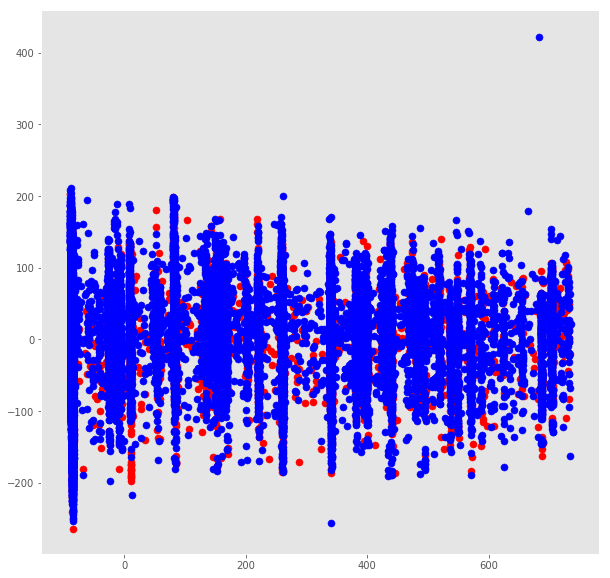

In [88]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)

targets = [1, 0]
colors = ['r', 'b']

for target, color in zip(targets,colors):
    indicesToKeep = pcs_final_df['result'] == target
    ax.scatter(pcs_final_df.loc[indicesToKeep, 'principal component 1']
               , pcs_final_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.grid()

##### Decision Tree
Coz, why not?

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

clf = tree.DecisionTreeClassifier(max_depth=3)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [135]:
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.7545626179987414

In [136]:
def measure_performance(X,y,clf, show_accuracy=True, show_classification_report=True, show_confusion_matrix=True):
    y_pred=clf.predict(X)   
    if show_accuracy:
        print ("Accuracy:{0:.3f}".format(accuracy_score(y,y_pred)),"\n")

    if show_classification_report:
        print ("Classification report")
        print (classification_report(y,y_pred),"\n")
        
    if show_confusion_matrix:
        print ("Confusion matrix")
        print (confusion_matrix(y,y_pred),"\n")
        
measure_performance(X_test,y_test,clf, show_classification_report=True, show_confusion_matrix=False)

Accuracy:0.755 

Classification report
             precision    recall  f1-score   support

          1       0.00      0.00      0.00       625
          2       0.00      0.00      0.00       666
          3       0.00      0.00      0.00       659
          4       0.75      1.00      0.86      5995

avg / total       0.57      0.75      0.65      7945
 



d:\users\lchan\documents\shelling-ford\venv\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [137]:
tree.export_graphviz(clf, out_file='dt.dot')

##### Keras
Time to try the real stuff.

My current thought is to:

1. Calculate a score for each entry
2. Compare score with other entries of the same race
3. Put in race details

In [180]:
df_all.columns

Index(['race_id', 'horse_no', 'horse_id', 'result', 'won', 'lengths_behind',
       'horse_age', 'horse_country', 'horse_type', 'horse_rating',
       'horse_gear', 'declared_weight', 'actual_weight', 'draw',
       'position_sec1', 'position_sec2', 'position_sec3', 'position_sec4',
       'position_sec5', 'position_sec6', 'behind_sec1', 'behind_sec2',
       'behind_sec3', 'behind_sec4', 'behind_sec5', 'behind_sec6', 'time1_x',
       'time2_x', 'time3_x', 'time4_x', 'time5_x', 'time6_x', 'finish_time',
       'win_odds', 'place_odds', 'trainer_id', 'jockey_id',
       'weight_difference', 'weight_difference_percentage', 'date', 'venue',
       'race_no', 'config', 'surface', 'distance', 'going', 'horse_ratings',
       'prize', 'race_class', 'sec_time1', 'sec_time2', 'sec_time3',
       'sec_time4', 'sec_time5', 'sec_time6', 'sec_time7', 'time1_y',
       'time2_y', 'time3_y', 'time4_y', 'time5_y', 'time6_y', 'time7',
       'place_combination1', 'place_combination2', 'place_combinat

In [181]:
df_race_agg

,race_id,horse_count,horse_age_mean,horse_age_std,horse_rating_mean,horse_rating_std,declared_weight_mean,declared_weight_std,actual_weight_mean,actual_weight_std,weight_difference_mean,weight_difference_std,weight_difference_percentage_mean,weight_difference_percentage_std
0,0,14,3.000000,0.000000,60.000000,0.000000,1064.357143,64.976454,125.785714,5.590907,938.571429,65.933200,7.479935,0.667454
1,1,14,3.000000,0.000000,60.000000,0.000000,1103.714286,58.050944,120.357143,8.176958,983.357143,56.390953,8.203974,0.702997
2,2,14,3.000000,0.000000,60.000000,0.000000,1079.642857,54.522553,122.857143,6.561627,956.785714,55.144814,7.813285,0.686353
3,3,12,3.000000,0.000000,60.000000,0.000000,1174.250000,51.047438,119.666667,8.456663,1054.583333,52.647124,8.858908,0.827792
4,4,14,3.000000,0.000000,60.000000,0.000000,1059.857143,61.466510,120.642857,9.426698,939.214286,62.682569,7.839795,0.935609
5,5,14,3.000000,0.000000,60.000000,0.000000,1115.500000,60.270863,123.928571,6.764890,991.571429,59.012012,8.021012,0.625531
6,6,12,3.000000,0.000000,60.000000,0.000000,1098.333333,63.614368,122.500000,6.431457,975.833333,65.657283,7.996981,0.839994
7,7,13,3.000000,0.000000,60.000000,0.000000,1140.000000,65.560405,119.384615,7.890273,1020.615385,67.312132,8.591957,0.885097
8,8,14,3.000000,0.000000,60.000000,0.000000,1110.500000,45.741330,121.285714,7.829221,989.214286,42.812972,8.182285,0.563901
9,9,14,3.000000,0.000000,60.000000,0.000000,1109.000000,60.742838,122.428571,7.324504,986.571429,61.151406,8.088229,0.726200


In [261]:
df_trial_2 = df_all[[
    'result', 'horse_age', 'horse_country', 'horse_type', 'horse_rating',
    'horse_gear', 'declared_weight', 'actual_weight', 'draw',
    'trainer_id', 'jockey_id', 'weight_difference', 'weight_difference_percentage', 
    'venue', 'surface', 'distance', 'going', 'prize', 'race_class', 
    'horse_ratings_lower', 'horse_ratings_upper', 'horse_count',
    'horse_age_mean', 'horse_age_std', 'horse_rating_mean',
    'horse_rating_std', 'declared_weight_mean', 'declared_weight_std',
    'actual_weight_mean', 'actual_weight_std', 'weight_difference_mean',
    'weight_difference_std', 'weight_difference_percentage_mean',
    'weight_difference_percentage_std'
]]

In [262]:
df_trial_2['horse_age_standardised'] = np.where(df_trial_2['horse_age_std'] == 0, 0, (df_trial_2['horse_age'] - df_trial_2['horse_age_mean'])/df_trial_2['horse_age_std'])
df_trial_2['horse_rating_standardised'] = np.where(df_trial_2['horse_rating_std'] == 0, 0, (df_trial_2['horse_rating'] - df_trial_2['horse_rating_mean'])/df_trial_2['horse_rating_std'])
df_trial_2['declared_weight_standardised'] = np.where(df_trial_2['declared_weight_std'] == 0, 0, (df_trial_2['declared_weight'] - df_trial_2['declared_weight_mean'])/df_trial_2['declared_weight_std'])
df_trial_2['actual_weight_standardised'] = np.where(df_trial_2['actual_weight_std'] == 0, 0, (df_trial_2['actual_weight'] - df_trial_2['actual_weight_mean'])/df_trial_2['actual_weight_std'])
df_trial_2['weight_difference_standardised'] = np.where(df_trial_2['weight_difference_std'] == 0, 0, (df_trial_2['weight_difference'] - df_trial_2['weight_difference_mean'])/df_trial_2['weight_difference_std'])
df_trial_2['weight_difference_percentage_standardised'] = np.where(df_trial_2['weight_difference_percentage_std'] == 0, 0, (df_trial_2['weight_difference_percentage'] - df_trial_2['weight_difference_percentage_mean'])/df_trial_2['weight_difference_percentage_std'])
df_trial_2['draw_standardised'] = df_trial_2['draw'] / df_trial_2['horse_count']

d:\users\lchan\documents\shelling-ford\venv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
d:\users\lchan\documents\shelling-ford\venv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
d:\users\lchan\documents\shelling-ford\venv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [187]:
df_trial_2.head()

,result,horse_age,horse_country,horse_type,horse_rating,horse_gear,declared_weight,actual_weight,draw,trainer_id,...,weight_difference_std,weight_difference_percentage_mean,weight_difference_percentage_std,horse_age_standardised,horse_rating_standardised,declared_weight_standardised,actual_weight_standardised,weight_difference_standardised,weight_difference_percentage_standardised,draw_standardised
0,10,3,AUS,Gelding,60,--,1020.0,133,7,118,...,65.9332,7.479935,0.667454,0.0,0.0,-0.682665,1.290361,-0.782177,-1.214709,0.500000
1,8,3,NZ,Gelding,60,--,980.0,133,12,164,...,65.9332,7.479935,0.667454,0.0,0.0,-1.298272,1.290361,-1.388852,-1.665304,0.857143
2,7,3,NZ,Gelding,60,--,1082.0,132,8,137,...,65.9332,7.479935,0.667454,0.0,0.0,0.271527,1.111499,0.173336,-0.423947,0.571429
3,9,3,SAF,Gelding,60,--,1118.0,127,13,80,...,65.9332,7.479935,0.667454,0.0,0.0,0.825574,0.217189,0.795177,0.484250,0.928571
4,6,3,GB,Gelding,60,--,972.0,131,14,9,...,65.9332,7.479935,0.667454,0.0,0.0,-1.421394,0.932637,-1.479853,-1.588256,1.000000


In [263]:
df_trial_2.columns

Index(['result', 'horse_age', 'horse_country', 'horse_type', 'horse_rating',
       'horse_gear', 'declared_weight', 'actual_weight', 'draw', 'trainer_id',
       'jockey_id', 'weight_difference', 'weight_difference_percentage',
       'venue', 'surface', 'distance', 'going', 'prize', 'race_class',
       'horse_ratings_lower', 'horse_ratings_upper', 'horse_count',
       'horse_age_mean', 'horse_age_std', 'horse_rating_mean',
       'horse_rating_std', 'declared_weight_mean', 'declared_weight_std',
       'actual_weight_mean', 'actual_weight_std', 'weight_difference_mean',
       'weight_difference_std', 'weight_difference_percentage_mean',
       'weight_difference_percentage_std', 'horse_age_standardised',
       'horse_rating_standardised', 'declared_weight_standardised',
       'actual_weight_standardised', 'weight_difference_standardised',
       'weight_difference_percentage_standardised', 'draw_standardised'],
      dtype='object')

In [264]:
df_trial_2_preprocessed = df_trial_2[[
    'result', 
    #'horse_country', 'horse_type', 'horse_gear', 'trainer_id', 'jockey_id', 'venue', 'surface', 'going', 
    #'distance', 'race_class', 
    'horse_age_standardised',
    'horse_rating_standardised', 'declared_weight_standardised',
    'actual_weight_standardised', 'weight_difference_standardised',
    'weight_difference_percentage_standardised', 'draw_standardised'
]]
df_trial_2_preprocessed.shape
df_trial_2_preprocessed.isnull().any()

result                                       False
horse_age_standardised                       False
horse_rating_standardised                    False
declared_weight_standardised                 False
actual_weight_standardised                   False
weight_difference_standardised               False
weight_difference_percentage_standardised    False
draw_standardised                            False
dtype: bool

In [275]:
model = Sequential()
model.add(Dense(128, 
                  input_shape=(len(df_trial_2_preprocessed.columns) - 1,), 
                  activation=None))
model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.1))

model.add(Dense(256, activation=None))
model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.1))

model.add(Dense(256, activation=None))
model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.1))

model.add(Dense(128, activation=None))
model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.1))

model.add(Dense(1, activation=None))
model.add(Activation('sigmoid'))

model.compile(optimizer=Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              loss='binary_crossentropy',
              metrics=[metrics.binary_accuracy])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_102 (Dense)            (None, 128)               1024      
_________________________________________________________________
leaky_re_lu_75 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_103 (Dense)            (None, 256)               33024     
_________________________________________________________________
leaky_re_lu_76 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_104 (Dense)            (None, 256)               65792     
__________

In [266]:
Y = df_trial_2_preprocessed['result']
X = df_trial_2_preprocessed.drop('result', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [276]:
save_model_name = "keiba_model_g1.h5"
checkpointer = ModelCheckpoint(filepath='../results/'+save_model_name, verbose=0)

model.fit(x=X_train, 
          y=y_train, 
          batch_size=64, 
          epochs=5, 
          verbose=1, 
          callbacks=[checkpointer],
          validation_split=0.2,
          shuffle=True)

Train on 57201 samples, validate on 14301 samples
Epoch 1/5
57201/57201 [==============================] - 9s 160us/step - loss: -84.5311 - binary_accuracy: 0.0802 - val_loss: -93.6423 - val_binary_accuracy: 0.0797
Epoch 2/5
57201/57201 [==============================] - 8s 132us/step - loss: -92.9648 - binary_accuracy: 0.0803 - val_loss: -93.6444 - val_binary_accuracy: 0.0797
Epoch 3/5
57201/57201 [==============================] - 8s 135us/step - loss: -92.9652 - binary_accuracy: 0.0803 - val_loss: -93.6444 - val_binary_accuracy: 0.0797
Epoch 4/5
57201/57201 [==============================] - 8s 137us/step - loss: -92.9653 - binary_accuracy: 0.0803 - val_loss: -93.6444 - val_binary_accuracy: 0.0797
Epoch 5/5
57201/57201 [==============================] - 8s 136us/step - loss: -92.9653 - binary_accuracy: 0.0803 - val_loss: -93.6444 - val_binary_accuracy: 0.0797
